<a href="https://colab.research.google.com/github/aneesh-shetye/VFP_ODE/blob/main/toy_deq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import jax
import jax.numpy as jnp
from jax import random
from jax import lax, vmap
from jax import jit, grad
from functools import partial
import numpy.random as npr

import matplotlib.pyplot as plt


In [ ]:
# toy deq fixed point layer:

def fixed_point_layer(solver, f, params, x):
  '''
  takes in solver, f-> function for which to find the fixed point
  paramters of the function and x-> input values
  '''
  z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
  return z_star

  ## DOUBTS: why are we passing x and z, both as input to f?



In [ ]:
# example f:

f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)


In [ ]:
# initializing wights and inputs to some random value:

ndim = 10
W = random.normal(random.PRNGKey(0), (ndim, ndim))/jnp.sqrt(ndim)
x = random.normal(random.PRNGKey(1), (ndim,))


In [ ]:
# Newton Solver:

# naive forward iterations till a threshold
def fwd_solver(f, z_init):
  z_prev, z = z_init, f(z_init)
  while jnp.linalg.norm(z_prev - z) > 1e-5:
    z_prev, z = z, f(z)
  return z


def newton_solver(f, z_init):
  f_root = lambda z: f(z) - z
  g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))
  #jnp.linalg.solve computes the exact solution, x of a full rank linear matrix equation: ax = b
  # here: coeff matrix = jacobian of f at z and dependant variable is f at z
  return fwd_solver(g, z_init)


In [ ]:
z_star = fixed_point_layer(fwd_solver, f, W, x)
print(z_star)

[ 0.00649598 -0.70159584 -0.984715   -0.04196559 -0.6152218  -0.4818382
  0.5783123   0.9556704  -0.08373147  0.8447805 ]


In [ ]:
f(W, x, z_star) - z_star

Array([-3.2181852e-06,  1.3709068e-06, -5.9604645e-08,  9.8347664e-07,
        1.1920929e-06, -4.1723251e-07,  2.3841858e-07,  1.1920929e-07,
        3.6582351e-06, -1.0132790e-06], dtype=float32)

## Finding the gradiant using VJP:

We have:
$$∂ z^*(a_0) = [I - ∂_1 f(a_0, z_0)]^{-1} ∂_0 f(a_0, z_0)$$

Using VJP we would get the following kind of equation:

$\tag{1} w^T ∂z^*(a_0) = w^T [I - ∂_1 f(a_0, z_0]^{-1} ∂_0 f(a_0, z_0)$

Let,
$$u^T = w^T[I - ∂_1 f(a_0, z_0)]^{-1}$$

Rearranging this equation we get:
$$\tag{2} u^T = w^T + u^T ∂_1 f(a_0, z_0)$$

Then, we can solve it as a fixed point iteration problem

upon finding say $(u^T)^*$, we can then find $∂z^*(a_0)$ using $(2)$

In [ ]:
#defining the forward and backward passes for fixed point iteration:

@partial(jax.custom_vjp, nondiff_argnums=(0,1))
def fixed_point_layer_fwd(solver, f, params, x):
  z_star = fixed_point_layer(solver, f, params, x)
  return z_star, (params, x, z_star)

def fixed_point_layer_bwd(solver, f, res, z_star_bar):
  params, x, z_star = res
  _, vjp_a = jax.vjp(lambda params, x: f(params, x, z_star), params, x)
  _, vjp_z = jax.vjp(lambda z: f(params, x, z), z_star)

  return vjp_a(solver(lambda u: vjp_z(u)[0] + z_star_bar, z_init=jnp.zeros_like(z_star)))



Building `odeint` using custom_jvp. odeint takes in a function, time and initial value and gives out the value of the function.





In [ ]:
#using euler's method:

def odeint_euler(f, y0, t, *args):
  def step(state, t):
    y_prev, t_prev = state
    dt = t-t_prev
    y = y_prev + dt*f(y_prev, t_prev, *args)
    return (y,t), y
  _, ys = lax.scan(step, (y0, t[0]), t[1:])
  return ys


## Building a neural ODE:

In [ ]:
#defining an mlp:

def mlp(params, inputs):
  outputs = inputs
  for w, b in params:

    outputs = jnp.dot(outputs, w) + b
    outputs = jnp.tanh(outputs)
  return outputs


In [ ]:
#concatenate system state and current time and send it to mlp
def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)


In [ ]:
#passing dynamics function through odeint
from jax.experimental.ode import odeint

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state


In [ ]:
#creating a batched odenet
#this creates parallel solvers
batched_odenet = vmap(odenet, in_axes=(None, 0))

In [ ]:
#defining the loss_function:
resnet_depth = 3

def mse_loss(params, inputs, trg):
  preds = resnet(params, inputs, resnet_depth)
  return jnp.mean(jnp.sum((preds-trg)**2, axis=1))


In [ ]:
from re import DEBUG
#defining updates - simple backprop:
#check how grad works

#DOUBT: Wrong code in the source

def resnet(params, inputs, depth):
  # outputs = inputs
  x_new = inputs
  for i in range(depth):
    # inputs = outputs
    x_old = x_new
    x = mlp(params, x_old)
    x_new = x + x_old

  return x_new

#blog resnet def
# def resnet(params, inputs, depth):

#   for i in range(depth):
#     # inputs = outputs
#     outputs = mlp(params, inputs) + inputs
#   return outputs


@jit
def resnet_update(params, step_size, inputs, trg):
  grads = grad(mse_loss)(params, inputs, trg)
  # print([(dw[1], db[1]) for dw, db in grads])
  return [(w - step_size*dw, b - step_size*db) for (w,b), (dw, db) in zip(params, grads)]


In [ ]:
# print(resnet_params)

In [ ]:
inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 10), (10,1))
targets = inputs**3 + 0.1*inputs

#setting hyperparameters:
layer_sizes = [1,20, 1]
param_scale = 0.1
step_size = 0.1
train_iters = 1000

#initialize and train:
def init_random_params(scale, layer_sizes, rng=npr.RandomState(2)):
  return [(scale*rng.randn(m,n), scale*rng.randn(n))
    for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

resnet_params = init_random_params(param_scale, layer_sizes)

for i in range(train_iters):
  resnet_params = resnet_update(resnet_params, step_size, inputs, targets)
  # print(resnet_params[0][0])


# print(resnet_params[0][0])
# print(f'resnet_update: {resnet_update(resnet_params, step_size=0.01, inputs=inputs, trg=targets)[0][0]}')

In [ ]:
resnet_params[0][0].shape

(1, 20)

In [ ]:
# inputs, targets

Text(0, 0.5, 'output')

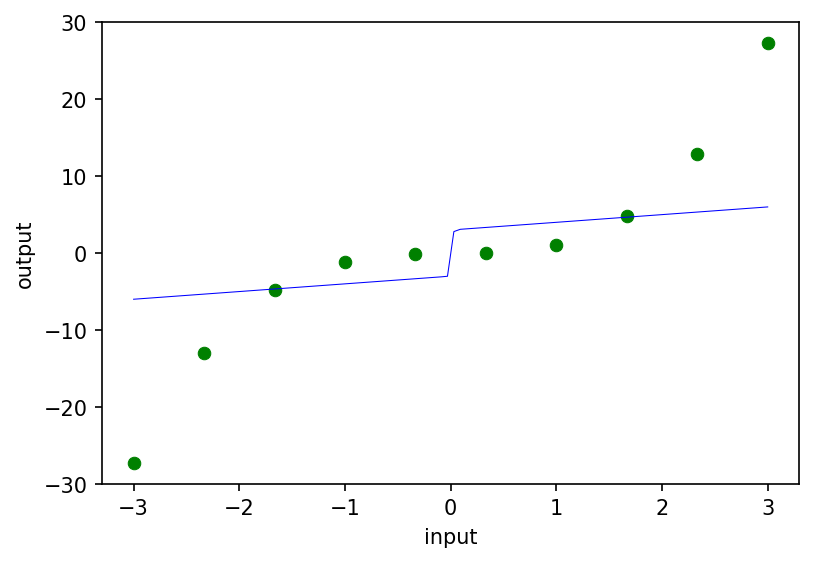

In [ ]:
#plotting results:

fig = plt.figure(figsize=(6,4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')

fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))

ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')

ax.set_xlabel('input')
ax.set_ylabel('output')


In [ ]:
#odenet loss similar to resnet_loss:

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds-targets)**2, axis=1))

@jit
def odenet_update(params, step_size, inputs, trg):
  grads = grad(odenet_loss)(params, inputs, trg)

  return [(w - step_size*dw, b - step_size*db) for (w,b), (dw, db) in zip(params, grads)]



In [ ]:

#initializing and training odenet:

odenet_layer_sizes = [2, 20, 1]

odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, step_size, inputs, targets)



(-1.5, 1.5)

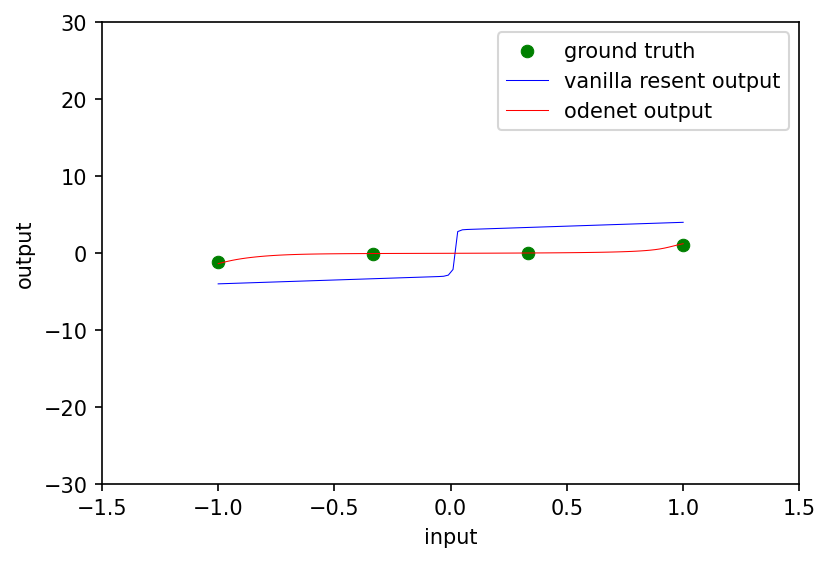

In [56]:
#plotting results:

fig = plt.figure(figsize=(6,4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')

fine_inputs = jnp.reshape(jnp.linspace(-1.0, 1.0, 100), (100, 1))

ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')

ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(['ground truth', 'vanilla resent output', 'odenet output'])

plt.xlim(-1.5, 1.5)


Text(0, 0.5, 'time/depth')

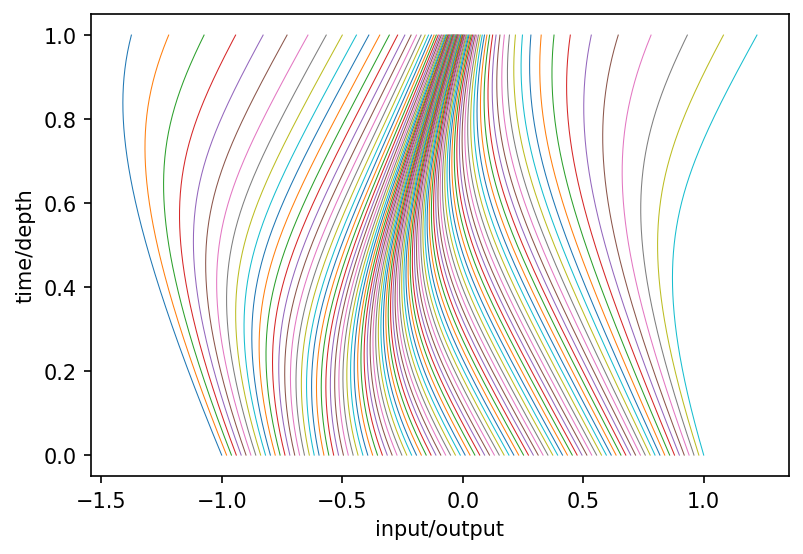

In [55]:
# plotting the activation trajectories of odenet:
fig = plt.figure(figsize=(6,4), dpi=150)
ax = fig.gca()

#DOUBT: error in blog implementation: "input" is a python keyword
@jit
def odenet_times(params, inputs, times):
  return odeint(nn_dynamics, inputs, times, params)

times = jnp.linspace(0.0, 1.0, 200)

for i in fine_inputs:
  ax.plot(odenet_times(odenet_params, i, times), times, lw=0.5)

ax.set_xlabel('input/output')
ax.set_ylabel('time/depth')